# Visualizing Housing Costs in New York City

All data was obtained from the U.S. Census Bureau's American Community Survey (2016).

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(sys.version)

3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


In [3]:
data = pd.read_csv(os.getcwd() + '\\data\\ACS_16_5YR_DP04_with_ann.csv', 
                   skiprows=1,sep=',', encoding='ISO-8859-1', dtype='object')

In [4]:
data.head()

,Id,Id2,Geography,Estimate; HOUSING OCCUPANCY - Total housing units,Margin of Error; HOUSING OCCUPANCY - Total housing units,Percent; HOUSING OCCUPANCY - Total housing units,Percent Margin of Error; HOUSING OCCUPANCY - Total housing units,Estimate; HOUSING OCCUPANCY - Total housing units - Occupied housing units,Margin of Error; HOUSING OCCUPANCY - Total housing units - Occupied housing units,Percent; HOUSING OCCUPANCY - Total housing units - Occupied housing units,...,Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 30.0 to 34.9 percent,Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 30.0 to 34.9 percent,Estimate; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Estimate; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed,Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed,Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed,Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed
0,0500000US01001,1001,"Autauga County, Alabama",22714,75,22714,(X),20800,391,91.6,...,9.5,4.8,2302,488,46.2,7.4,602,175,(X),(X)
1,0500000US01003,1003,"Baldwin County, Alabama",107579,202,107579,(X),75149,1285,69.9,...,9.5,1.7,7389,578,40.1,2.9,2840,449,(X),(X)
2,0500000US01005,1005,"Barbour County, Alabama",11802,101,11802,(X),9122,286,77.3,...,9.7,4.1,1128,187,42.3,5.3,626,149,(X),(X)
3,0500000US01007,1007,"Bibb County, Alabama",8972,76,8972,(X),7048,352,78.6,...,13,9.2,473,156,31,9.4,401,145,(X),(X)
4,0500000US01009,1009,"Blount County, Alabama",23850,59,23850,(X),20619,403,86.5,...,9.2,3.8,1096,216,33.8,5.4,1121,225,(X),(X)


In [5]:
data.columns

Index(['Id', 'Id2', 'Geography',
       'Estimate; HOUSING OCCUPANCY - Total housing units',
       'Margin of Error; HOUSING OCCUPANCY - Total housing units',
       'Percent; HOUSING OCCUPANCY - Total housing units',
       'Percent Margin of Error; HOUSING OCCUPANCY - Total housing units',
       'Estimate; HOUSING OCCUPANCY - Total housing units - Occupied housing units',
       'Margin of Error; HOUSING OCCUPANCY - Total housing units - Occupied housing units',
       'Percent; HOUSING OCCUPANCY - Total housing units - Occupied housing units',
       ...
       'Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 30.0 to 34.9 percent',
       'Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 30.0 to 34.9 percent',
       'Estimate; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GR

In [6]:
#collect columns showcasing housing unit counts partitioned by estimated home value.
homeValues = data.filter(regex='Geography|Estimate.*VALUE.*Owner.*\$.*').copy()
homeValues.columns = ['County',
                      'Less_than_$50,000',
                      '\$50,000_to_$99,999',
                      '\$100,000_to_$149,999',
                      '\$150,000_to_$199,999',
                      '\$200,000_to_$299,999',
                      '\$300,000_to_$499,999',
                      '\$500,000_to_$999,999',
                      '\$1,000,000_or_More']

In [7]:
#collect columns showcasing housing unit counts partitioned by gross rent payments.
rentValues = data.filter(regex='Geography|Estimate.*RENT.*\$.*').copy()
rentValues.columns = ['County',
                      'Less_than_$500',
                      '\$500_to_$999',
                      '\$1,000_to_$1,499',
                      '\$1,500_to_$1,999',
                      '\$2,000_to_$2,499',
                      '\$2,500_to_$2,999',
                      '\$3,000_or_More']

In [8]:
vehicleValues = data.filter(regex='Geography|Estimate.*VEHICLES.*units -.*').copy()
vehicleValues.columns = ['County',
                         'None',
                         'One',
                         'Two',
                         'Three_or_More']

In [9]:
#specify NYC counties
boroughs = ['Richmond County, New York',
            'Kings County, New York',
            'New York County, New York',
            'Bronx County, New York',
            'Queens County, New York']

def selector(df, rows):
    #set counties and set index
    df = df[df['County'].isin(rows)]
    df = df.set_index('County')
    return df

#select nyc counties and set index
homeValues = selector(df=homeValues, rows=boroughs)
rentValues = selector(df=rentValues, rows=boroughs)
vehicleValues = selector(df=vehicleValues, rows=boroughs)

In [10]:
def bracket_df(df):
    #melt dataframe into unit counts for each price bracket
    group, value = [], []
    for idx in df.index:
        for col in df.columns:
            count = int(df.loc[idx, col])
            group += count * [idx]
            value += count * [col]

    categories = df.columns
    
    df = pd.DataFrame({'Borough': group,
                       'Value': value})

    value_dict = dict(zip(categories,list(range(len(categories)))))
    
    borough_dict = {'Richmond County, New York': 'Staten Island',
                    'Kings County, New York': 'Brooklyn',
                    'Queens County, New York': 'Queens',
                    'Bronx County, New York': 'The Bronx',
                    'New York County, New York': 'Manhattan'}
    
    df['Borough'] = df['Borough'].replace(borough_dict)
    df['Value'] = df['Value'].replace(value_dict)
    return df, value_dict

In [11]:
def borough_joyplot(df, value_dict, title, text_coords, shade_color, line_color, bandwidth, save=False):
    #Inspired by https://github.com/aaronpenne
        
    ## Set up plotting and formatting
    sns.set(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

    font_h1 = {'family': 'Tahoma',
               'color': 'black',
               'weight': 'bold',
               'size': 22,
               'horizontalalignment': 'center'}

    font_h2 = {'family': 'Tahoma',
               'color': 'black',
               'size': 16,
               'horizontalalignment': 'center'}

    font_sub = {'family': 'Tahoma',
                'color': 'black',
                'weight': 'regular',
                'size': 12,
                'horizontalalignment': 'right'}

    # Create axes for each Year, one row per Year
    palette = sns.color_palette(shade_color).as_hex()
    rows = ['The Bronx','Staten Island','Queens','Brooklyn','Manhattan']
    g = sns.FacetGrid(data=df,
                      row='Borough',  # Determines which value to group by
                      hue='Borough',  # Similar to row. Enables labels on each subplot
                      aspect=5,   # Controls aspect ratio of entire figure
                      size=2.0,    # Controls vertical height of each subplot
                      row_order=['The Bronx','Staten Island','Queens','Brooklyn','Manhattan'],
                      palette={k:v for k,v in zip(rows, palette)})  

    # KDE area plots
    g.map(sns.kdeplot, 'Value', bw=bandwidth, clip_on=False, shade=True, alpha=1.0)

    # KDE lines for outlining areas
    g.map(sns.kdeplot, 'Value', bw=bandwidth, clip_on=False, color=line_color)

    # psuedo x-axes
    g.map(plt.axhline, y=0, lw=2, clip_on=False, color='black')

    # Define and use a simple function to label the plot in axes coordinates
    # https://seaborn.pydata.org/examples/kde_joyplot.html
    def label(x, color, label):
        ax = plt.gca()
        ax.set_xlim([-2,len(df['Value'].unique())])
        ax.text(0, 0.07, 
                label,
                family='Tahoma',
                fontsize=14,
                color='black', 
                ha='left',
                va='center',
                transform=ax.transAxes)
        return

    g.map(label, 'Value')

    # Overlap the plots to give the ridgeline effect
    g.fig.subplots_adjust(hspace=-.7)

    # Clean up axes and remove subplot titles
    g.set_titles('')
    g.set(yticks=[])
    plt.xticks(list(value_dict.values()), 
               [x.replace('_','\n') for x in list(value_dict.keys())],
                fontsize=14,
                fontname='Tahoma')
    plt.xlabel('')
    g.despine(bottom=True, left=True)

    # Add titles and annotations
    x, y = text_coords
    plt.text(0.75*x, y + 0.038*y,
             title,
             fontdict=font_h1)
    plt.text(0.75*x, y,
             'Percent of housing units in each bracket (2016)',
             fontdict=font_h2)
    plt.text(x, -0.17*y,
             '© David Ascienzo 2018',
             fontdict=font_sub)
    if save:
        plt.savefig('_'.join(title.split()) + '.png',
                    format='png',
                    dpi=300,
                    bbox_inches='tight')
    plt.show()
    return

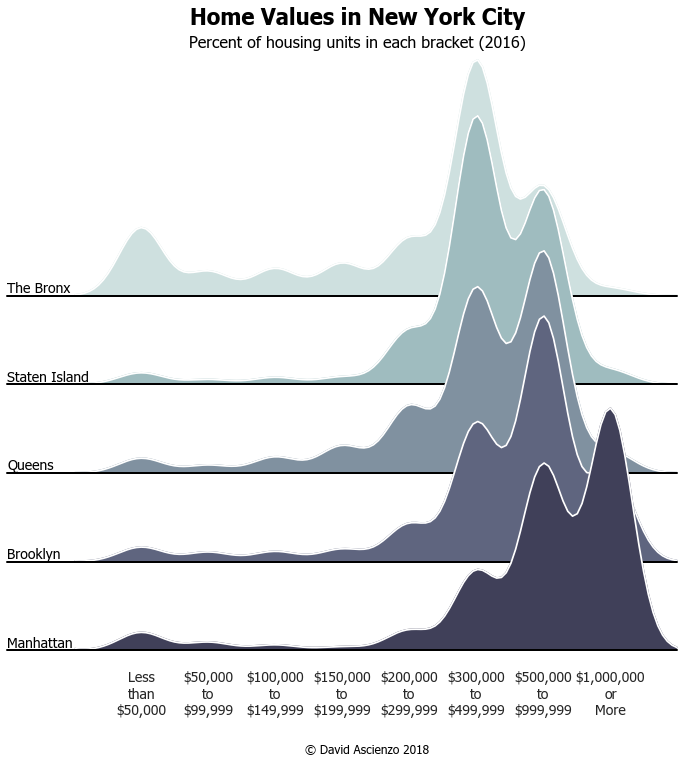

In [12]:
#home value plots
u, v = bracket_df(df=homeValues)
borough_joyplot(df=u, value_dict=v, title='Home Values in New York City', text_coords=(4.3, 1.3), 
                shade_color='bone_r', line_color='#FFFFFF', bandwidth=0.33, save=True)

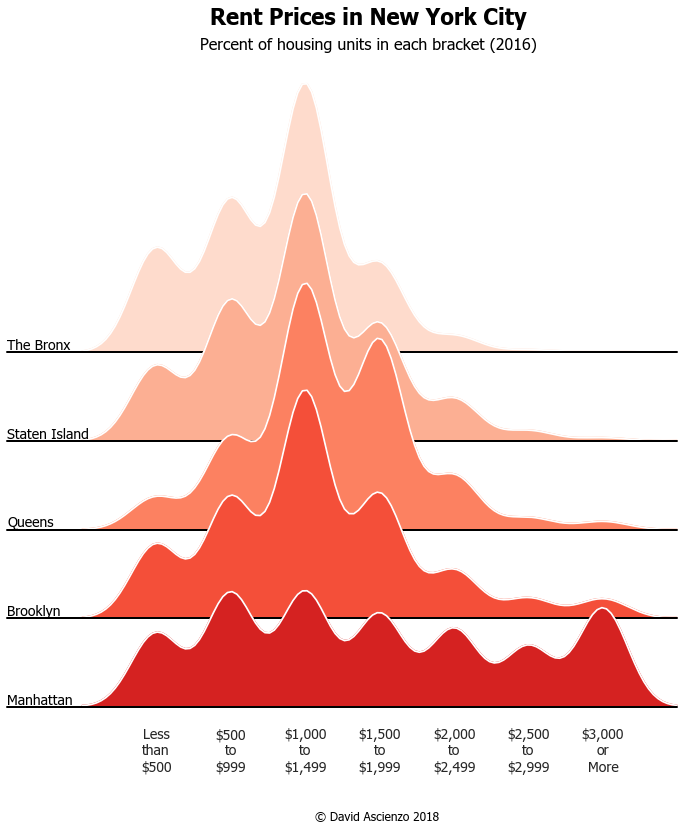

In [13]:
#rent pricing plots
u, v = bracket_df(df=rentValues)
borough_joyplot(df=u, value_dict=v, title='Rent Prices in New York City', text_coords=(3.8,1.25), 
                shade_color='Reds', line_color='#FFFFFF', bandwidth=0.33, save=True)

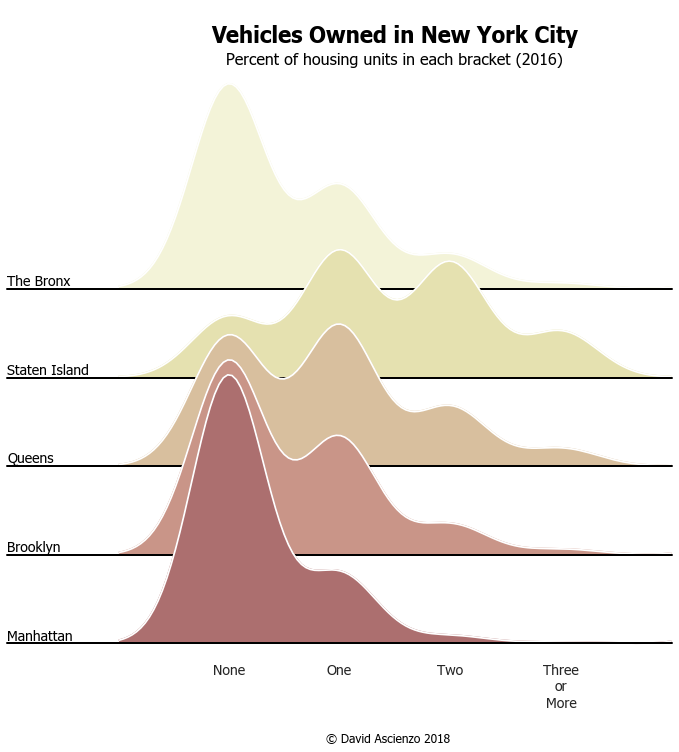

In [14]:
#home value plots
u, v = bracket_df(df=vehicleValues)
borough_joyplot(df=u, value_dict=v, title='Vehicles Owned in New York City', text_coords=(2.0, 2.0), 
                shade_color='pink_r', line_color='#FFFFFF', bandwidth=0.33, save=True)